In [1]:
import json
with open('lrs\gpt2-large_lora_lr_data.json', 'r') as f:
    history = json.load(f)

In [2]:
def running_average(data: list, window: int):
    """
    Calculates the running average of given data points using their timestamps.
    
    :param data: List of (timestamp, value) tuples
    :param window: Time window for running average
    :return: List of (timestamp, average) tuples
    """
    if not data:
        return []
    
    # sort data by timestamp
    data = sorted(data, key=lambda x: x[0])
    
    # initialize the list of results
    averages = []
    
    # go through the data
    for i in range(len(data)):
        current_time = data[i][0]
        sum_values = 0
        sum_weights = 0
        
        # go through the data in the window
        for j in range(i, -1, -1):
            time_diff = current_time - data[j][0]
            
            # if the timestamp is out of the window
            if time_diff > window:
                break
            
            # weight by the time interval
            weight = 1 if j == i else time_diff
            sum_values += data[j][1] * weight
            sum_weights += weight
        
        # calculate the average
        average = sum_values / sum_weights if sum_weights > 0 else 0
        averages.append((current_time, average))
    
    return averages

# Example data: [(timestamp, value), ... ]
data = [
    (1, 3),
    (2, 4),
    (5, 5),
    (8, 2),
    (10, 8)
]

# Window for running average (in the same units as timestamp)
window = 3

# Calculating the running average
smoothed_data = running_average(data, window)

# Printing the smoothed data
for timestamp, average in smoothed_data:
    print(f"Timestamp: {timestamp}, Average: {average:.2f}")


Timestamp: 1, Average: 3.00
Timestamp: 2, Average: 3.50
Timestamp: 5, Average: 4.25
Timestamp: 8, Average: 4.25
Timestamp: 10, Average: 4.00


In [2]:
def exponential_moving_average(data: list, alpha: float):
    """
    Calculates the exponential moving average of given data points using their timestamps.
    
    :param data: List of (timestamp, value) tuples
    :param alpha: Smoothing factor between 0 and 1. Higher values give more weight to recent data.
    :return: List of (timestamp, average) tuples
    """
    if not data:
        return []
    
    # sort data by timestamp
    data = sorted(data, key=lambda x: x[0])
    
    # initialize the list of results
    averages = []
    
    # initialize the EMA
    ema = data[0][1]
    
    # go through the data
    for i in range(len(data)):
        current_time = data[i][0]
        value = data[i][1]
        
        # calculate the EMA
        ema = (1 - alpha) * ema + alpha * value
        averages.append((current_time, ema))
    
    return averages

# Example data: [(timestamp, value), ... ]
data = [
    (1, 3),
    (2, 4),
    (5, 5),
    (8, 2),
    (10, 8)
]

# Smoothing factor between 0 and 1. 
# A higher value of alpha means that the EMA adapts more quickly to changes in the data.
alpha = 0.2

# Calculating the exponential moving average
smoothed_data = exponential_moving_average(data, alpha)

# Printing the smoothed data
for timestamp, average in smoothed_data:
    print(f"Timestamp: {timestamp}, Average: {average:.2f}")


Timestamp: 1, Average: 3.00
Timestamp: 2, Average: 3.20
Timestamp: 5, Average: 3.56
Timestamp: 8, Average: 3.25
Timestamp: 10, Average: 4.20


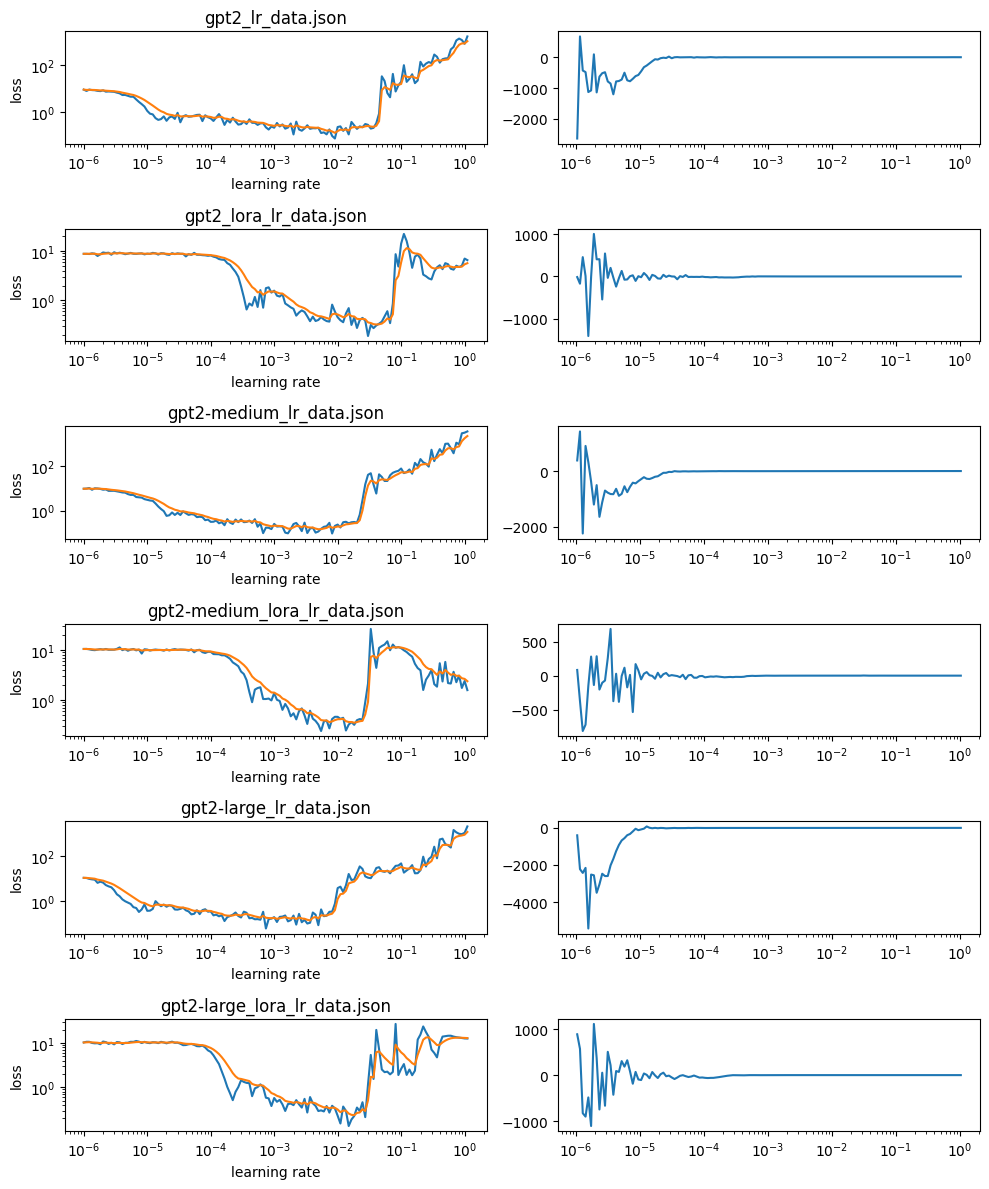

In [4]:
import os
import json
import matplotlib.pyplot as plt

counter = 0
files = [file for file in os.listdir('lrs')]
fig, axs = plt.subplots(len(files), 2, figsize=(10, 12))
for file in reversed(files):
    with open(os.path.join('lrs', file), 'r') as f:
        lr_history = json.load(f)

        lrs = []
        losses = []

        for lr, loss in lr_history:
            lrs.append(lr)
            losses.append(loss)
            
        smooth_lr = []
        smooth_losses = []
        
        smoothed = exponential_moving_average(lr_history, 0.25)
        for lr, loss in smoothed:
            smooth_lr.append(lr)
            smooth_losses.append(loss)

        dLr = []
        dLoss = []
        for i in range(len(smoothed)-1):
            lr1, loss1 = smoothed[i]
            lr2, loss2 = smoothed[i+1]
            a = (loss2 - loss1)/(lr2 - lr1)
            dLr.append((lr1+lr2)/2)
            dLoss.append((a)/1000)
        
        axs[counter, 0].plot(lrs, losses)
        axs[counter, 0].plot(smooth_lr, smooth_losses)
        axs[counter, 0].set_xscale('log')
        axs[counter, 0].set_yscale('log')
        axs[counter, 0].set_title(file.replace(".json", ""))
        axs[counter, 0].set_xlabel("learning rate")
        axs[counter, 0].set_ylabel("loss")
        
        axs[counter, 1].plot(dLr, dLoss)
        axs[counter, 1].set_xscale('log')

        counter += 1

fig.tight_layout()

plt.savefig("lrs.png", dpi=300)
# Show the plot
plt.show()

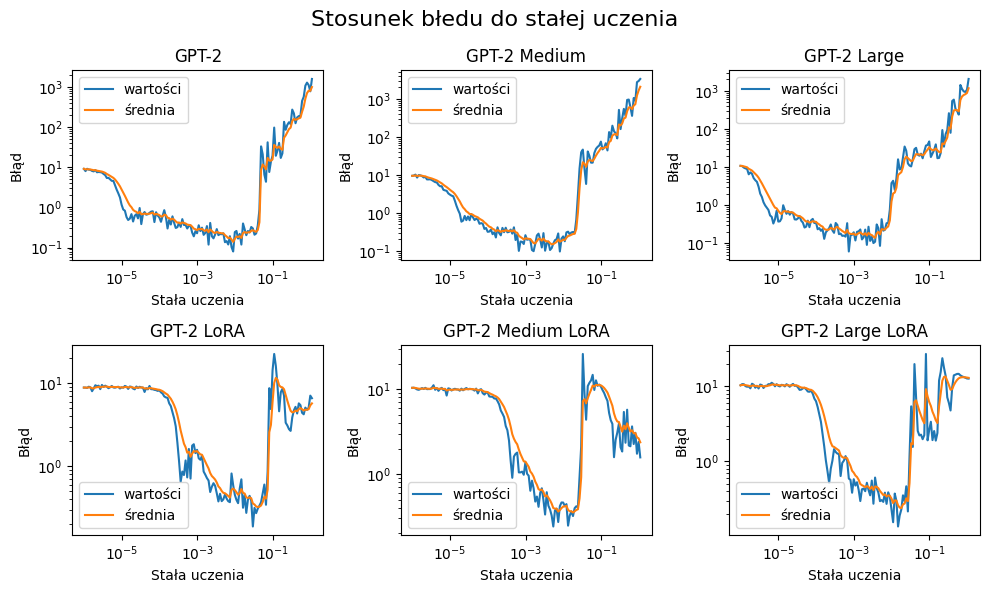

In [5]:
import os
import json
import matplotlib.pyplot as plt

counter = 0
files = [file for file in os.listdir('lrs')]
fig, axs = plt.subplots(2, len(files)//2, figsize=(10, 6))
fig.suptitle("Stosunek błedu do stałej uczenia", fontsize=16)
for file in reversed(files):
    with open(os.path.join('lrs', file), 'r') as f:
        lr_history = json.load(f)

        lrs = []
        losses = []

        for lr, loss in lr_history:
            lrs.append(lr)
            losses.append(loss)
            
        smooth_lr = []
        smooth_losses = []
        
        smoothed = exponential_moving_average(lr_history, 0.25)
        for lr, loss in smoothed:
            smooth_lr.append(lr)
            smooth_losses.append(loss)

        dLr = []
        dLoss = []
        for i in range(len(smoothed)-1):
            lr1, loss1 = smoothed[i]
            lr2, loss2 = smoothed[i+1]
            a = (loss2 - loss1)/(lr2 - lr1)
            dLr.append((lr1+lr2)/2)
            dLoss.append((a)/1000)
        
        axis = 1 if "lora" in file else 0
        name = file.replace("gpt2", "GPT-2").replace("-medium", " Medium").replace("-large", " Large").replace("_lr_data.json", "").replace("_lora", "") + (" LoRA" if axis == 1 else "")

        axs[axis, counter//2].plot(lrs, losses, label="wartości")
        axs[axis, counter//2].plot(smooth_lr, smooth_losses, label="średnia")
        axs[axis, counter//2].set_xscale('log')
        axs[axis, counter//2].set_yscale('log')
        axs[axis, counter//2].set_title(name)
        axs[axis, counter//2].set_xlabel("Stała uczenia")
        axs[axis, counter//2].set_ylabel("Błąd")
        axs[axis, counter//2].legend(loc='best')
        
        counter += 1

fig.tight_layout()

plt.savefig("lrs.png", dpi=300)
# Show the plot
plt.show()

In [15]:
import matplotlib.pyplot as plt
lrs = []
losses = []
for lr, loss in history:
    lrs.append(lr)
    losses.append(loss)

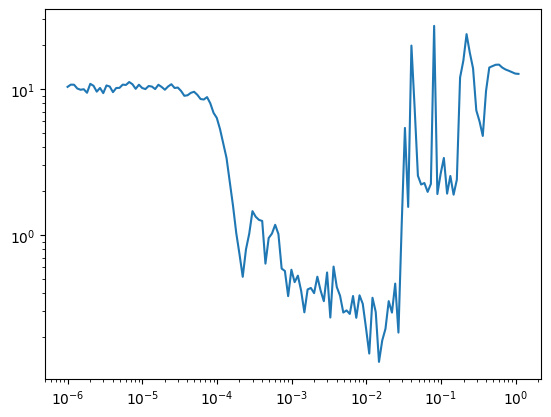

In [16]:
plt.plot(lrs, losses)
plt.xscale("log")
plt.yscale("log")

In [17]:
dLr = []
dLoss = []
for i in range(len(history)-1):
    lr1, loss1 = history[i]
    lr2, loss2 = history[i+1]
    a = (loss2 - loss1)/(lr2 - lr1)
    dLr.append((lr1+lr2)/2)
    dLoss.append(a)

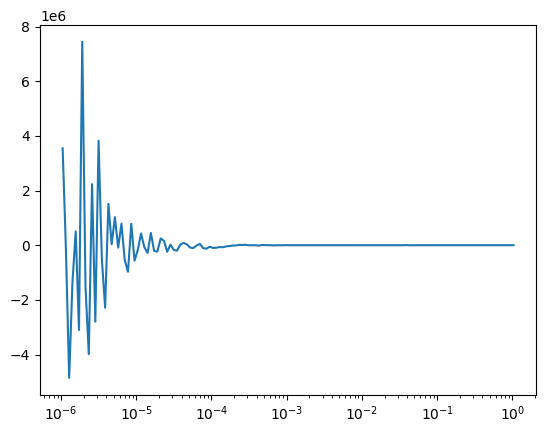

In [20]:
plt.plot(dLr, dLoss)
plt.xscale("log")

In [16]:
min_value = min(dLoss)
min_index = dLoss.index(min_value)
dLr[min_index]

1.7354200355453186e-05

In [3]:
len(history)

117

In [2]:
from math import exp, log

In [9]:
a = 1e-6

In [15]:
10*log(1/a)

138.15510557964274